# Classifying Networks

- Vítor AMorim Fróis

In [111]:
import os
import math

import networkx as nx
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from dataclasses import dataclass

### Reading Networks

In [112]:
@dataclass
class Network:
    graph: nx.Graph
    name: str
    network_type: str
    metrics: np.array


In [113]:
network_dir = 'data/assignment_5'
real_networks_list: list[Network] = []

for network_type in tqdm(os.listdir(network_dir)):
    for file in os.listdir(f'{network_dir}/{network_type}'):
        file_full_path = f'{network_dir}/{network_type}/{file}'
        file_format = file.split('.')[-1]
        if file_format == 'csv':
            df = pd.read_csv(file_full_path)
            df = df[df.columns[0:2]] # get first two columns
            graph = nx.from_pandas_edgelist(df=df, source=df.columns[0], target=df.columns[1])
        elif file_format == 'edgelist':
            graph = nx.read_edgelist(file_full_path, data=(('weight', int),))
        elif file_format == 'gml':
            graph = nx.read_gml(file_full_path, label = 'id')
        elif file_format == 'graphml':
            graph = nx.read_graphml(file_full_path)

        largest_component = max(nx.connected_components(graph), key=len)
        graph = graph.subgraph(largest_component)

        graph = graph.to_undirected()
        graph.remove_edges_from(nx.selfloop_edges(graph))

        real_networks_list.append(
            Network(
                graph=graph,
                name=file,
                network_type=network_type,
                metrics=None
            )
        )


100%|██████████| 3/3 [00:00<00:00, 15.44it/s]


## Characterize Networks

In [114]:
class NetworkMeasure:
    nxgraph: nx.Graph
    measure_dict: dict[str, float]
    degree_values: np.array
    degree_probability: np.array

    def __init__(self, graph: nx.Graph):
        self.graph = graph

    def get_measure_dict(self) -> dict[str, float]:
        measure_dict = {
            'clustering': self.clustering(),
            'closeness': self.closeness(),
            'betweenness': self.betweenness(),
            'assortativity': self.assortativity(),
            # 'information_centrality': self.information_centrality(),
            # 'approximate_current_flow_betweenness_centrality': self.approximate_current_flow_betweenness_centrality(),
            'shannon_entropy': self.shannon_entropy(),
            'degree_variance': self.degree_variance(),
            'average_degree': self.average_degree()
        }
        return measure_dict

    def clustering(self) -> float:
        return nx.transitivity(self.graph)

    def closeness(self) -> float:
        return np.mean(list(nx.closeness_centrality(self.graph).values()))

    def betweenness(self) -> float:
        return np.mean(list(nx.betweenness_centrality(self.graph).values()))
    
    def eigenvector(self) -> float:
        return np.mean(list(nx.eigenvector_centrality(self.graph).values()))

    def assortativity(self) -> float:
        return nx.degree_assortativity_coefficient(self.graph)

    def information_centrality(self) -> float:
        return np.mean(list(nx.information_centrality(self.graph).values()))

    def approximate_current_flow_betweenness_centrality(self) -> float:
        return np.mean(list(nx.approximate_current_flow_betweenness_centrality(self.graph).values()))

    def shannon_entropy(self) -> float:
        k, Pk = self.degree_distribution()
        H = 0
        for p in Pk:
            if (p > 0):
                H -= p * math.log(p, 2)
        return H

    def degree_variance(self) -> float:
        k, Pk = self.degree_distribution()
        return np.std(k)

    def average_degree(self) -> float:
        k, _ = self.degree_distribution()
        return np.mean(k)

    def degree_distribution(self):
        degree_list = np.array(list(dict(self.graph.degree()).values()))
        max_degree = np.max(degree_list)
        degree_values = np.arange(0, max_degree + 1)
        degree_probability = np.zeros(max_degree + 1)

        for k in degree_list:
            degree_probability[k] += 1

        degree_probability = degree_probability/sum(degree_probability)
        return degree_values, degree_probability

## Generate Random Networks

In [115]:
@dataclass
class NetworkSpec:
    name: str
    function: callable
    kwargs: dict

def get_random_network_spec(n_nodes: int, average_degree: float) -> list[NetworkSpec]:
    return [
        NetworkSpec(
            'barabasi_linear',
            ig.Graph.Barabasi,
            kwargs={
                'n': n_nodes, 'm': 5, 
                'outpref': True, 
                'directed': False, 
                'power': 1.0, 
                'zero_appeal': 1, 
                'implementation': "psumtree", 
                'start_from': None
            }
        ),
        NetworkSpec(
            'barabasi_nonlinear_05',
            ig.Graph.Barabasi,
            kwargs={
                'n': n_nodes, 'm': 5, 
                'outpref': True, 
                'directed': False, 
                'power': 0.5, 
                'zero_appeal': 1, 
                'implementation': "psumtree", 
                'start_from': None
            }
        ),
        NetworkSpec(
            'barabasi_nonlinear_15',
            ig.Graph.Barabasi,
            kwargs={
                'n': n_nodes, 'm': 5, 
                'outpref': True, 
                'directed': False, 
                'power': 1.5, 
                'zero_appeal': 1, 
                'implementation': "psumtree", 
                'start_from': None
            }
        ),
        NetworkSpec(
            'waxman',
            nx.waxman_graph,
            kwargs={
                'n': n_nodes, 
                'seed': None
            }
        ),
        NetworkSpec(
            'erdos_renyi',
            nx.erdos_renyi_graph,
            kwargs={'n': n_nodes, 'p': average_degree/(n_nodes-1)}
        ),
        NetworkSpec(
            'watts-strogatz',
            nx.watts_strogatz_graph, 
            kwargs={
                'n': n_nodes,
                'k': int(np.ceil(average_degree)),
                'p': 0.1
            }
        )
    ]
        

In [116]:
def get_random_networks(n_nodes, average_degree, n_networks: int = 10) -> list[Network]:
    random_network_spec = get_random_network_spec(n_nodes, average_degree)
    random_network_list = []
    for spec in tqdm(random_network_spec):
        for i in tqdm(range(n_networks), leave=False):
            graph = spec.function(**spec.kwargs)
            if not isinstance(graph, nx.Graph):
                graph = graph.to_networkx()
            random_network_list.append(
                Network(
                    graph=graph,
                    name=spec.name,
                    network_type='random',
                    metrics=None
                )
            )
    return random_network_list

## Analyzing Real Networks

### Rat Brain

In [117]:
real_network = real_networks_list[0]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

rat_brain.csv
biological


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.167711,0.450241,0.005379,-0.799867,2.80914,42.434263,73.0


#### Computing Metrics

In [17]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(np.unique(error_log))

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [00:34<00:00,  1.74it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.611275,-0.563714,0.422895,-0.112470,-0.200484,-0.439104,-0.439236
1,-0.608959,-0.541439,0.396666,-0.345299,-0.204015,-0.150463,-0.150582
2,-0.580249,-0.541569,0.397701,-0.322030,-0.146873,-0.035011,-0.035120
3,-0.599746,-0.552970,0.410954,-0.236465,-0.184282,-0.294782,-0.294909
4,-0.620639,-0.542749,0.398461,-0.332480,-0.267610,-0.265918,-0.266043


#### PCA and KNN

In [21]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)

X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)

encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(metric_df, class_list)
most_similar_random_graph = knn.predict(pd.DataFrame([real_graph_metrics]))

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'rat_brain.csv is closer to barabasi_nonlinear_15')

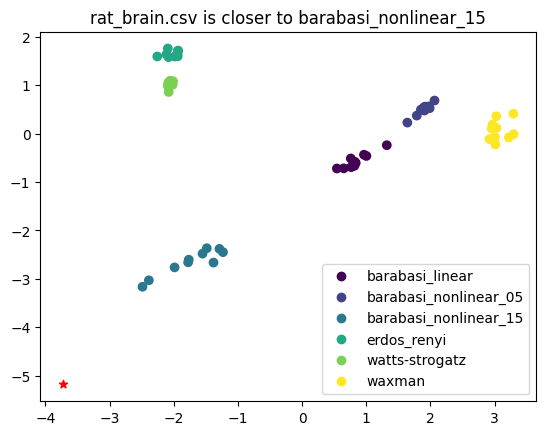

In [22]:
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Food Web

In [143]:
real_network = real_networks_list[1]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

foodweb.edgelist
biological


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.311915,0.567805,0.006161,-0.111663,5.327094,32.04164,55.0


#### Computing Metrics

In [144]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 20)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 120/120 [00:16<00:00,  7.14it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.593355,-0.274629,0.025094,-0.293637,0.194118,-0.081108,-0.081398
1,-0.625139,-0.305325,0.053965,-0.183365,0.323414,-0.497634,-0.498032
2,-0.549817,-0.304008,0.055285,0.048841,0.135839,-0.358785,-0.359154
3,-0.565630,-0.290767,0.040437,-0.273890,-0.069683,-0.405067,-0.405447
4,-0.552633,-0.276359,0.028394,-0.123289,0.191670,0.057723,0.057480


#### PCA and KNN

In [145]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'foodweb.edgelist is closer to erdos_renyi')

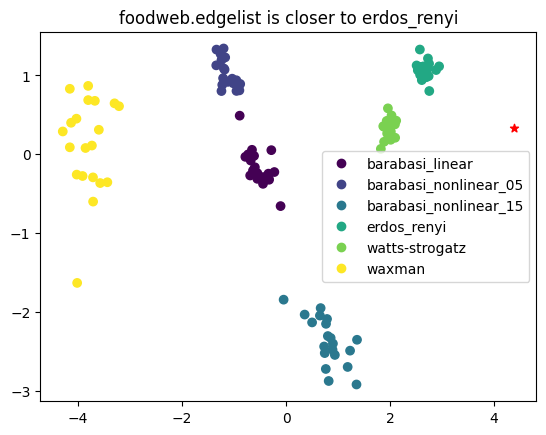

In [147]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Connectome

In [148]:
real_network = real_networks_list[2]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

budapest_connectome.graphml
biological


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.120394,0.215773,0.008439,-0.20046,3.049803,27.422618,47.0


#### Computing Metrics

In [149]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 20)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 120/120 [02:32<00:00,  1.27s/it]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.500207,-0.803727,0.806904,-0.267503,-0.184304,0.136020,0.135976
1,-0.499420,-0.859435,0.882414,-0.075951,-0.159474,0.136020,0.135976
2,-0.501567,-0.826344,0.832732,-0.313782,-0.216057,-0.256500,-0.256532
3,-0.515660,-0.859181,0.877301,-0.094028,-0.150145,-0.060238,-0.060278
4,-0.504040,-0.860202,0.879170,-0.101909,-0.136647,-0.270519,-0.270551


#### PCA and KNN

In [150]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'budapest_connectome.graphml is closer to barabasi_nonlinear_05')

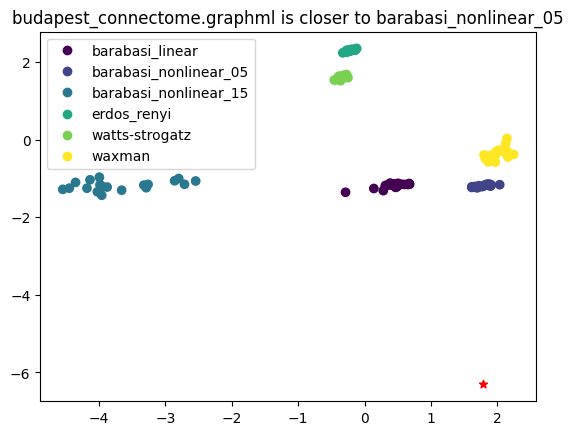

In [151]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Chile Power Grid

In [152]:
real_network = real_networks_list[3]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

chile_power.csv
tech


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.087977,0.128213,0.02074,-0.077264,2.267098,7.211103,12.0


#### Computing Metrics

In [153]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 10)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [00:26<00:00,  2.22it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.387858,0.313779,-0.397141,-0.519994,0.260003,0.202515,0.202393
1,-0.398720,0.187893,-0.281477,-0.199259,0.346249,-0.049078,-0.049201
2,-0.406783,0.260733,-0.352025,-0.510737,0.271163,0.118653,0.118529
3,-0.406682,0.160565,-0.255885,-0.133755,0.436216,0.353466,0.353350
4,-0.409697,0.250946,-0.340417,-0.347838,0.337985,0.168970,0.168848


#### PCA and KNN

In [154]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)

encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'chile_power.csv is closer to watts-strogatz')

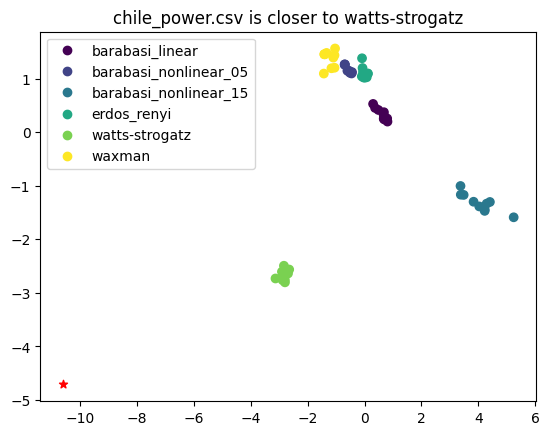

In [155]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### US Power

In [119]:
real_network = real_networks_list[4]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

us_power.edgelist
tech


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.035255,0.057898,0.016774,0.09004,2.003676,3.162278,5.0


#### Computing Metrics

In [120]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(np.unique(error_log))

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [04:37<00:00,  4.62s/it]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.461941,0.243361,-0.450858,-0.113443,0.296062,-0.183903,-0.183993
1,-0.460332,0.240208,-0.449488,-0.125465,0.283086,-0.183903,-0.183993
2,-0.451728,0.242453,-0.450534,-0.173125,0.280417,-0.178846,-0.178935
3,-0.448002,0.275599,-0.464787,-0.227518,0.277120,0.170081,0.170001
4,-0.468746,0.241480,-0.450066,-0.185113,0.293121,-0.092877,-0.092966


#### PCA and KNN

In [127]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)

X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)

encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'us_power.edgelist is closer to watts-strogatz')

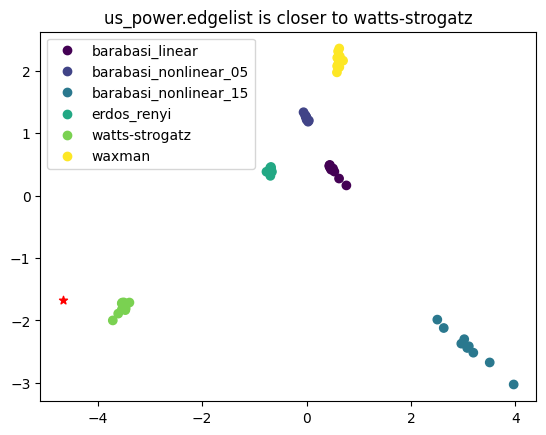

In [128]:
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### JMail

In [129]:
real_network = real_networks_list[5]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

jmail.edgelist
tech


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.194779,0.282019,0.014037,-0.240679,3.322772,14.142136,24.0


#### Computing Metrics

In [130]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 10)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [00:11<00:00,  5.11it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,-0.451814,-0.185658,0.041956,-0.114387,0.327448,0.389125,0.388996
1,-0.416415,-0.175000,0.030958,-0.296188,0.259141,0.349502,0.349370
2,-0.469442,-0.197376,0.053695,-0.085480,0.373120,-0.046743,-0.046891
3,-0.461056,-0.133807,-0.008090,-0.526469,0.236368,0.349502,0.349370
4,-0.399808,-0.179639,0.038125,-0.089483,0.371855,0.468370,0.468249


#### PCA and KNN

In [131]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'jmail.edgelist is closer to barabasi_nonlinear_05')

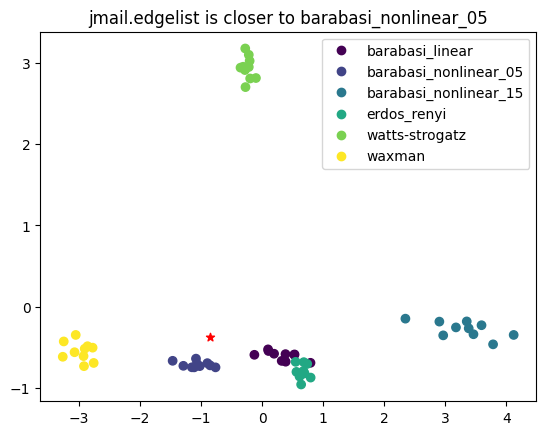

In [132]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Cattle

In [133]:
real_network = real_networks_list[6]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

cattle.edgelist
social


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.648597,0.688911,0.018417,-0.132868,3.811844,6.63325,11.0


#### Computing Metrics

In [134]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 10)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [00:00<00:00, 228.85it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.271517,0.373179,0.634730,0.710714,0.700541,0.126880,0.124568
1,0.345476,0.425392,0.505303,-0.222564,0.931529,0.611565,0.612010
2,0.172585,0.420825,0.505303,0.099243,0.682833,0.288473,0.287049
3,0.355824,0.413204,0.548446,-0.260356,0.572684,0.773073,0.774491
4,0.230402,0.423477,0.494518,-0.115589,0.693657,0.288473,0.287049


#### PCA and KNN

In [136]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'cattle.edgelist is closer to barabasi_nonlinear_15')

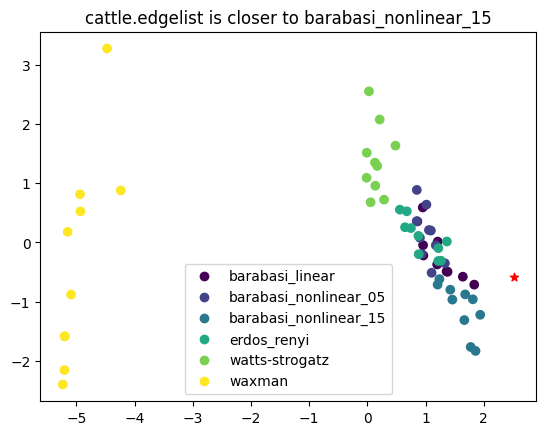

In [137]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Medici

In [138]:
real_network = real_networks_list[7]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

medici_network.gml
social


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.191489,0.415096,0.114286,-0.374838,2.072906,2.0,3.0


#### Computing Metrics

In [139]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 10)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

 48%|████▊     | 29/60 [00:00<00:00, 286.60it/s]/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
100%|██████████| 60/60 [00:00<00:00, 382.71it/s]


[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,1.080023,0.914755,-0.475446,-0.081264,0.805806,1.060258,1.062984
1,0.901497,0.917936,-0.475446,-0.283168,0.954677,1.060258,1.062984
2,0.967440,0.914650,-0.475446,0.043489,1.067057,1.060258,1.062984
3,0.934328,0.916975,-0.475446,-0.503953,0.918187,1.060258,1.062984
4,0.962592,0.913266,-0.475446,-0.194287,0.974377,0.854767,0.855235


In [140]:
metric_df = metric_df.dropna(how='any',axis=0)
class_list = np.array(class_list)[list(metric_df.index)]

#### PCA and KNN

In [141]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(X, class_list)
most_similar_random_graph = knn.predict(X_test)

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'medici_network.gml is closer to erdos_renyi')

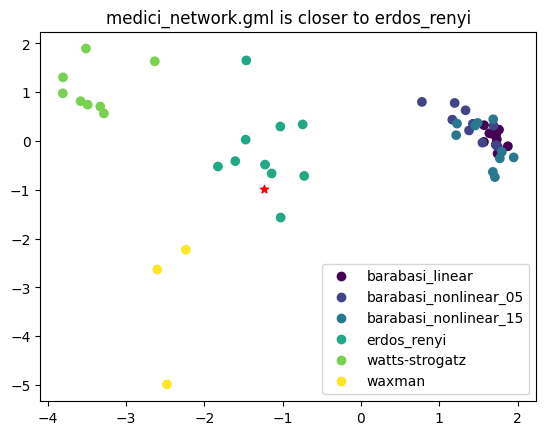

In [142]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

### Karate

In [106]:
real_network = real_networks_list[8]
print(real_network.name)
print(real_network.network_type)

metrics = NetworkMeasure(real_network.graph)
real_graph_metrics = metrics.get_measure_dict()

pd.DataFrame([real_graph_metrics])

karate.gml
social


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.255682,0.42648,0.044006,-0.475613,2.857222,5.188127,8.5


#### Computing Metrics

In [107]:
N = len(real_network.graph)
average_degree = real_graph_metrics['average_degree']

random_nets = get_random_networks(N, average_degree, 10)
metrics_list = []
class_list = []

error_log = []

for network in tqdm(random_nets):
    try:
        metrics = NetworkMeasure(network.graph)
        network_metrics = metrics.get_measure_dict()
        metrics_list.append(network_metrics)
        class_list.append(network.name)
    except Exception as e:
        error_log.append(e)

print(error_log)

metric_df = pd.DataFrame(metrics_list)
scaler = StandardScaler()
metric_df[metric_df.columns] = scaler.fit_transform(metric_df)
metric_df.head()

100%|██████████| 60/60 [00:00<00:00, 131.23it/s]

[]


,clustering,closeness,betweenness,assortativity,shannon_entropy,degree_variance,average_degree
0,0.285807,0.513800,0.248981,0.999367,0.757936,0.337242,0.336205
1,0.218703,0.541439,0.190004,0.443286,0.923722,1.081596,1.083327
2,0.267357,0.548146,0.184106,-0.363858,0.714803,1.081596,1.083327
3,0.436173,0.543282,0.201799,-0.428599,0.561010,1.230422,1.232751
4,0.316185,0.564478,0.160515,-0.828139,0.696578,0.932758,0.933903


In [108]:
metric_df = metric_df.dropna(how='any',axis=0)
class_list = np.array(class_list)[list(metric_df.index)]

#### PCA and KNN

In [109]:
pca = PCA(n_components=2)
pca.fit(metric_df)
X = pca.transform(metric_df)
X_test = pca.transform(
    scaler.transform(
        pd.DataFrame([real_graph_metrics])
    )
)
encoder = LabelEncoder()
encoded_list = encoder.fit_transform(class_list)

knn = KNeighborsClassifier()
knn.fit(metric_df, class_list)
most_similar_random_graph = knn.predict(pd.DataFrame([real_graph_metrics]))

/home/vitor/Documents/usp/9thPeriod/ComplexNetworks/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Plot

Text(0.5, 1.0, 'karate.gml is closer to barabasi_nonlinear_15')

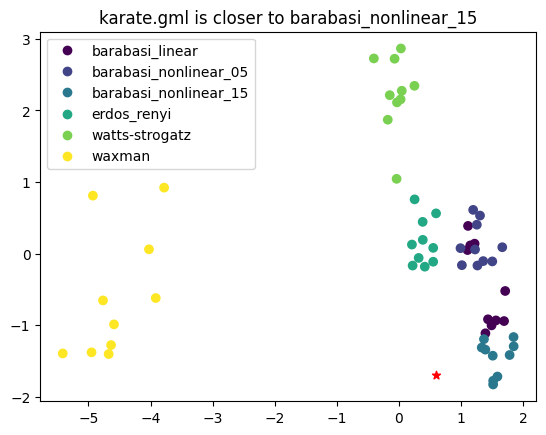

In [110]:
scatter = plt.scatter(X[:, 0], X[:, 1], c=encoded_list)
plt.scatter(X_test[:, 0], X_test[:, 1], c='red', marker='*')
plt.legend(
    handles=scatter.legend_elements()[0], 
    labels=list(np.unique(class_list))
)
plt.title(f'{real_network.name} is closer to {most_similar_random_graph[0]}')

## Conclusão

A hipótese não é verdadeira. Apenas redes que caracterizam dinâmicas muito similares possuem a mesma classificação. Exemplos são Power Grids, caracterizadas como Watts Strogatz e algumas redes biológicas de interação caraterizadas como Barabasi Albert 